In [2]:
import csv
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from environment.environment import Environment

from train.train import train_agent

from agents.mab_agent import MAB_Agent
from agents.mc_agent import MC_Agent
from agents.sarsa_agent import SARSA_Agent
from agents.dqn_agent import DQN_Agent

In [4]:
tickers = ["AAPL", "AMZN", "GOOGL", "MSFT", "NVDA", "TSLA"]

data = {i: {t: float(row[t]) for t in tickers} \
    for i, row in enumerate(csv.DictReader( \
    open("data/nasdaq_stock_prices.csv", mode='r'), delimiter=','))
}

In [9]:
INITIAL_BALANCE = 10000
WINDOW_SIZE = 5
EPISODES = 1000
VERBOSE = False
LOW_EPSILON = 0.1
HIGH_EPSILON = 0.5
GAMMA = 0.95
ALPHA = 0.3

environment = Environment(data, window_size=WINDOW_SIZE, initial_balance=INITIAL_BALANCE, verbose=VERBOSE)

In [10]:
mab_agent_low = MAB_Agent(environment, epsilon=LOW_EPSILON)
mab_agent_high = MAB_Agent(environment, epsilon=HIGH_EPSILON)

mc_agent_low = MC_Agent(environment, epsilon=LOW_EPSILON, gamma=GAMMA)
mc_agent_high = MC_Agent(environment, epsilon=HIGH_EPSILON, gamma=GAMMA)

sarsa_agent_low = SARSA_Agent(environment, epsilon=LOW_EPSILON, gamma=GAMMA)
sarsa_agent_high = SARSA_Agent(environment, epsilon=HIGH_EPSILON, alpha=ALPHA, gamma=GAMMA)

# dqn_agent_low = DQN_Agent(environment, epsilon=LOW_EPSILON, gamma=GAMMA)
# dqn_agent_high = DQN_Agent(environment, epsilon=HIGH_EPSILON, alpha=ALPHA, gamma=GAMMA)

results_mab_agent_low = train_agent(mab_agent_low, environment, episodes=EPISODES, verbose=VERBOSE)
results_mab_agent_high = train_agent(mab_agent_high, environment, episodes=EPISODES, verbose=VERBOSE)

results_mc_agent_low = train_agent(mc_agent_low, environment, episodes=EPISODES, verbose=VERBOSE)
results_mc_agent_high = train_agent(mc_agent_high, environment, episodes=EPISODES, verbose=VERBOSE)

results_sarsa_agent_low = train_agent(sarsa_agent_low, environment, episodes=EPISODES, verbose=VERBOSE)
results_sarsa_agent_high = train_agent(sarsa_agent_high, environment, episodes=EPISODES, verbose=VERBOSE)

# results_dqn_agent_low = train_agent(dqn_agent_low, environment, episodes=EPISODES, verbose=VERBOSE)
# results_dqn_agent_high = train_agent(dqn_agent_high, environment, episodes=EPISODES, verbose=VERBOSE)

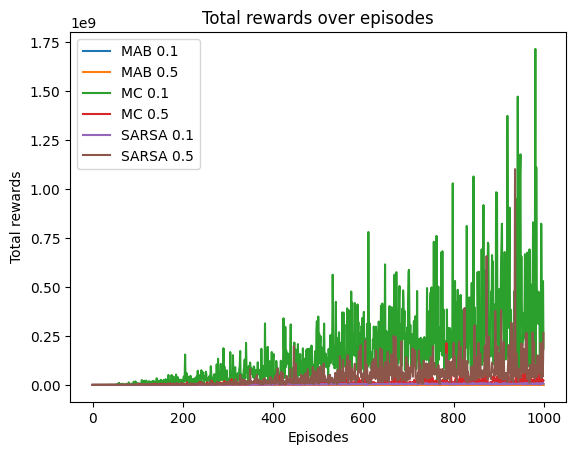

MAB with epsilon = 0.1:  16482.974108821414
MAB with epsilon = 0.5:  24612.334029603975
MC with epsilon = 0.1:  167122087.7876686
MC with epsilon = 0.5:  11342335.760901004
SARSA with epsilon = 0.1:  3191434.1048580324
SARSA with epsilon = 0.5:  44669820.470494844


In [11]:
plt.plot(results_mab_agent_low, label=f"MAB {mab_agent_low.epsilon}")
plt.plot(results_mab_agent_high, label=f"MAB {mab_agent_high.epsilon}")

plt.plot(results_mc_agent_low, label=f"MC {mc_agent_low.epsilon}")
plt.plot(results_mc_agent_high, label=f"MC {mc_agent_high.epsilon}")

plt.plot(results_sarsa_agent_low, label=f"SARSA {sarsa_agent_low.epsilon}")
plt.plot(results_sarsa_agent_high, label=f"SARSA {sarsa_agent_high.epsilon}")
# plt.plot(results_dqn_agent_low, label=f"DQN {dqn_agent_low.epsilon}")
# plt.plot(results_dqn_agent_high, label=f"DQN {dqn_agent_high.epsilon}")
plt.legend()
plt.title("Total rewards over episodes")
plt.xlabel("Episodes")
plt.ylabel("Total rewards")
plt.show()

print("MAB with epsilon = 0.1: ", np.mean(results_mab_agent_low))
print("MAB with epsilon = 0.5: ", np.mean(results_mab_agent_high))

print("MC with epsilon = 0.1: ", np.mean(results_mc_agent_low))
print("MC with epsilon = 0.5: ", np.mean(results_mc_agent_high))

print("SARSA with epsilon = 0.1: ", np.mean(results_sarsa_agent_low))
print("SARSA with epsilon = 0.5: ", np.mean(results_sarsa_agent_high))

# print("DQN with epsilon = 0.1: ", np.mean(results_dqn_agent_low))
# print("DQN with epsilon = 0.5: ", np.mean(results_dqn_agent_high))